# Policy Gradient - REINFORCE

This code is an example using Policy Gradient Method. The code is from [this website](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63).
The example uses the gym [CartPole system](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).
Here we use [pyTorch](https://pytorch.org/) rather than [tensorFlow](https://www.tensorflow.org/). 
- `torch.nn` is used to inherit and use the neural network class.
- `torch.nn.functional` is used to apply ReLU or softmax.
- `torch.optim` is used to apply [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/), a famous method for stochastic gradient descent.
- `torch.autograd`'s `Variable` is known to be deprecated [[REF]](https://stackoverflow.com/questions/57580202/whats-the-purpose-of-torch-autograd-variable), but since the original code uses it we will leave it as it is.

In [3]:
import sys
import gym
import time
import numpy as np  

import torch  
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
from   torch.autograd import Variable

import matplotlib.pyplot   as plt
import moviepy.editor as mpy


# Defining a Policy Network

The policy neural network has three layers:
- [Layer 1] Denoted as $l_1$ with $n_s$ Neurons. The input is the state of the current cart-and-pole.
- [Layer 2] Denoted as $l_2$ with $n_{h}$ Neurons, where subscript $h$ stands for "hidden".
- [Layer 3] Denoted as $l_3$ with $n_a$ Neurons

From $l_1$ to $l_2$ and $l_2$ to $l_3$, the network uses a linear combination, i.e., using $l_1$, $l_2$ and $l_3$ as an array of values of the corresponding neurons:
$$
\begin{align*}
    l_2 &= W_{12} \cdot l_1 + b_{12} \\
    l_3 &= W_{23} \cdot l_2 + b_{23}
\end{align*}    
$$
where $W$ and $b$ are weight matrix and bias array, respectively.
Note that the values are additionally fed into a nonlinear function.
$l_2$ is fed into a ReLU (Rectified Linear Unit) function, and $l_3$ is fed into a softmax function to make it as a probability distribution function (i.e., all the values are non-negative and it sums to 1)

In [4]:

class PolicyNetwork( nn.Module ):
    def __init__( self, num_inputs, num_actions, hidden_size, learning_rate = 3e-4 ):
        super( PolicyNetwork , self).__init__()

        self.num_actions = num_actions
        self.linear1     = nn.Linear( num_inputs, hidden_size  )
        self.linear2     = nn.Linear( hidden_size, num_actions )

        # Using the ADAM optimizer. 
        self.optimizer   = optim.Adam( self.parameters( ), lr = learning_rate )

    def forward( self, state ):
        x = F.relu( self.linear1( state ) )
        x = F.softmax( self.linear2( x ), dim = 1 )
        return x 
    
    def get_action( self, state ):
        state = torch.from_numpy( state ).float( ).unsqueeze( 0 ) # Makes a 1 x ns tensor.

        # Forward the neural network and return the prbability distribution function
        probs = self.forward( Variable( state ) )

        # Choosing the action based on the output policy
        highest_prob_action = np.random.choice( self.num_actions, p = np.squeeze( probs.detach( ).numpy( ) ) )

        # The log-value of the probability just for the sake of policy gradient
        log_prob = torch.log( probs.squeeze( 0 )[ highest_prob_action ] )
        
        return highest_prob_action, log_prob


# The Goal of Policy Gradient Method!

Once we parameterize the policy with a neural network $\pi_{\theta}(a|s)$, we need an objective function to conduct the gradient ascent (recall that we are optimizing rewards not costs!).
Given a trajectory $\tau$ of Markov Decision Process with length $T$ (starts from 0, hence $T+1$ states):
$$
    \tau: s_0, a_0, r_1, s_1, a_1, \cdots, s_{T-1}, a_{T-1}, r_T, s_T
$$

The objective function $J(\theta)$ that we are planning to maximize is the expected value of the reward from a given trajectory:
$$
    J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta} }\Big[R(\tau)\Big], \;\; \text{where} \;\;     R(\tau) =\sum_{i=1}^{T}r_i
$$
Note that the $R(\cdot)$ function is simply the sum of all rewards of a given trajectory, and subscript $\tau \sim \pi_{\theta}$ means that the trajectory is generated following policy $\pi_{\theta}$.
The gradient of the objective function is simply:
$$
    \nabla_{\theta} J(\theta) = \nabla_{\theta}\mathbb{E}_{\tau \sim \pi_{\theta} }\Big[R(\tau)\Big] = \nabla_{\theta}\mathbb{E}_{\tau \sim \pi_{\theta} }\bigg[ \sum_{i=1}^{T}r_i \bigg]
$$
Since it is the expectation over all possible trajectories, we use a simple trick to simplify the gradient:
$$
    \nabla_{\theta}\mathbb{E}_{\tau \sim \pi_{\theta} }\bigg[ R(\tau) \bigg] = \nabla_{\theta}\sum_{\tau} R(\tau) p_{\theta}(\tau) = \sum_{\tau} R(\tau) \nabla_{\theta} p_{\theta}(\tau) = \sum_{\tau} R(\tau) \frac{\nabla_{\theta} p_{\theta}(\tau)}{p_{\theta}(\tau)}p_{\theta}(\tau) = \sum_{\tau} R(\tau) p_{\theta}(\tau) \nabla_{\theta}\log{p_{\theta}(\tau)} = \mathbb{E}_{\tau \sim \pi_{\theta} }\Big[ R(\tau)\nabla_{\theta}\log{p_{\theta}(\tau)} \Big]
$$
Meaning, the gradient with respect to parameter $\theta$ goes into the expectation operator and we are taking the log of the probability of the trajectory. 
Our next step is to conduct a calculation of $p_{\theta}(\tau)$, $\log{p_{\theta}(\tau)}$:
$$
\begin{align*}
    p_{\theta}(\tau)       & = \text{Pr}\Big[ S_0 = s_0, A_0 = a_0, \cdots, S_{T-1}=s_{T-1}, A_{T-1}=a_{T-1} \Big] \\
                           & =  p(s_0)\cdot\pi_{\theta}(a_0|s_0)\cdot p(r_1, s_1 | a_0, s_0) \cdot \pi_{\theta}(a_1 | s_1) \cdot p(r_2, s_2 | a_1, s_1) \cdots \pi_{\theta}(a_{T-1}|s_{T-1})p(r_T, s_T | a_{T-1}, s_{T-1}) \\
                           \\
    \log{p_{\theta}(\tau)} & = \log{p(s_0)} + \log{\pi_{\theta}(a_0|s_0)} + \log{p(r_1, s_1 | a_0, s_0)} + \cdots + \log{\pi_{\theta}(a_{T-1}|s_{T-1})} + \log{p(r_T, s_T | a_{T-1}, s_{T-1})}  \\
    \\
    \nabla_{\theta}\log{p_{\theta}(\tau)} & = \nabla_{\theta} \bigg( \sum_{i=0}^{T-1} \log{\pi_{\theta}(a_i|s_i)} \bigg) 
\end{align*}    
$$
The great point about policy gradients is the fact that only the policy terms $\pi_{\theta}(a_i|s_i)$ survive for the gradient. Summarizing, 
$$
    \nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta} }\Big[ R(\tau)\nabla_{\theta}\log{p_{\theta}(\tau)} \Big] 
    = \mathbb{E}_{\tau \sim \pi_{\theta} }\Bigg[ R(\tau)\nabla_{\theta} \bigg( \sum_{i=0}^{T-1} \log{\pi_{\theta}(a_i|s_i)} \bigg)  \Bigg] 
    = \mathbb{E}_{\tau \sim \pi_{\theta} }\Bigg[ \bigg( \sum_{i=1}^{T}r_i \bigg) \nabla_{\theta} \bigg( \sum_{i=0}^{T-1} \log{\pi_{\theta}(a_i|s_i)} \bigg)  \Bigg]
$$
And using some math tricks for the simplification [[REF]](https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/):
$$
\mathbb{E}_{\tau \sim \pi_{\theta} }\Bigg[ \bigg( \sum_{i=1}^{T}r_i \bigg) \nabla_{\theta} \bigg( \sum_{i=0}^{T-1} \log{\pi_{\theta}(a_i|s_i)} \bigg)  \Bigg] = \cdots = \mathbb{E}_{\tau \sim \pi_{\theta} }\Bigg[ \sum_{i=0}^{T-1} \nabla_{\theta} \log{\pi_{\theta}(a_i|s_i)} \bigg(\sum_{j=i+1}^{T}r_j\bigg) \Bigg]
$$
Note that the last term is simply the undiscounted sum of rewards, i.e., $G_t$ with $\gamma = 1$. Meaning, we can simply generalize this equation for cases with $\gamma \in [0,1)$.

Summarizing, we calculate the gradient via:
$$
    \nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta} }\Bigg[ \sum_{i=0}^{T-1} \nabla_{\theta} \log{\pi_{\theta}(a_i|s_i)} G_t \Bigg]
$$



# REINFORCE Algorithm
Since we introduced the theory, we show the most basic algorithm called REINFORCE, which is a Monte-Carlo variant of policy gradients. Note that Monte-Carlo methods is simply a hard way of saying "methods using random samples".
The Monte-Carlo method is required since we cannot calculate actual "expectations" in real life $\mathbb{E}[\cdot]$. We need to somehow take samples and average it to calculate the expectations. 
The psuedo-code image is from [[REF]](http://www.cs.toronto.edu/~tingwuwang/REINFORCE.pdf).

# Speeding up the python code.
Before diving into the codes are some tips to speed-up the python code. One of the method is suppressing the usage of for-loops. 
In fact, for loops are known to be **Evil!** Please check out [this post](https://medium.com/python-pandemonium/never-write-for-loops-again-91a5a4c84baf) in case you are interested. Summarizing, it is a good exercise NOT to use for-loop, since there might be other ways that are way better and faster.

We present an example that calculates the $G_t$ array from a reward trajectory. Please check below for details.

In [6]:

def Gt_method1( r_arr: np.ndarray, gamma: float = 1, is_print: bool = False) :
    """
        This method uses vectors for the Gt array calculation.

        Args:
            [1] r_arr: an array of rewards for each time step. 

            [2] gamma: discount ratio, valued between 0 to 1. 
                       If gamma = 1, then there is no discount applied

            [3] is_print: a boolean value which determines whether to print out the computation time or not.

        Return:
            G_t: an array of discounted (or if gamma = 1, simple sum of) rewards
    """

    start = time.time()

    N = len( r_arr )

    tmp = np.concatenate( ( np.ones( 1 ), np.cumprod( gamma * np.ones( N - 1 ) ) ) )
    Gt_arr = np.flip( np.cumsum( tmp * r_arr  ) )

    if is_print: print( "[Method 1] [Vectorization]", time.time( ) - start) 

    return Gt_arr

def Gt_method2( r_arr: np.ndarray, gamma: float = 1, is_print: bool = False ):
    """
        This method uses a brute-force for loop executation for calculating the Gt array.

        Args:
            [1] r_arr: an array of rewards for each time step. 

            [2] gamma: discount ratio, valued between 0 to 1. 
                       If gamma = 1, then there is no discount applied

            [3] is_print: a boolean value which determines whether to print out the computation time or not.

        Return:
            G_t: an array of discounted (or if gamma = 1, simple sum of) rewards
    """

    start = time.time()
    Gt_arr = []

    for t in range( len( r_arr ) ) :

        # Initialization of Gt
        Gt = 0 

        # The power for the calculation
        pw = 0
        
        for r in r_arr[ t: ] :
            Gt += gamma ** pw * r
            pw += 1

        Gt_arr.append( Gt )

    if is_print: print( "[Method 2] [For-loop] ", time.time() - start )

    return Gt_arr

# Play with this number, the effect is in fact, dramatic
N     = 1000
r_arr = np.ones( N )

# _ is just to suppress the output print of the function
Gt1 = Gt_method1( r_arr, gamma = 1, is_print = True )
Gt2 = Gt_method2( r_arr, gamma = 1, is_print = True )

# For N = 1000, method1 takes an average of 0.0001 second, while method2 take 0.17s 
# Try it yourself!
Gt_calc = Gt_method2 

[Method 1] [Vectorization] 0.0004260540008544922
[Method 2] [For-loop]  0.3755760192871094


In [7]:
def update_policy( policy_network, rewards, log_probs, is_whitening = False ):
    """
        Args:
            log_probs: list of individual tensor with pi( at | st ) value.
    """

    # This is the discount rate, it should be smaller than 1 for convergence. 
    GAMMA  = 0.9

    # Calculate the Gt_arr for the training. 
    Gt_arr = Gt_calc( rewards, GAMMA, is_print = False )
    Gt_arr = torch.tensor( Gt_arr )

    # The Gt_arr method has high variant, hence there are tricks to suppress the high variance of the approach.
    # One basic approach is 
    if is_whitening: Gt_arr = ( Gt_arr - Gt_arr.mean( ) ) / ( Gt_arr.std( ) + 1e-9 ) 

    policy_gradient = []

    for log_prob, Gt in zip( log_probs, Gt_arr ):
        policy_gradient.append( -log_prob * Gt )
        
    # Initialize the gradient value to zero
    policy_network.optimizer.zero_grad( )
    
    policy_gradient = torch.stack( policy_gradient ).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()  

    

    

# Normalization of $G_t$?
Due to practical reason, just directly using the Gt values lead to unstable + highly-variant result of the learning process. 
Thus, there are tricks that can be applied. 
The most common one is the **whitening transformation**, which is mentioned in [this post](https://medium.com/nerd-for-tech/policy-gradients-reinforce-with-baseline-6c871a3a068). 
The idea is simple: just change the $G_t$ via normalization:

$$
    \nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta} }\Bigg[ \sum_{i=0}^{T-1} \nabla_{\theta} \log{\pi_{\theta}(a_i|s_i)} G_t \Bigg] \;\; \Longrightarrow \;\; \nabla_{\theta} J(\theta) = \mathbb{E}_{\tau \sim \pi_{\theta} }\Bigg[ \sum_{i=0}^{T-1} \nabla_{\theta} \log{\pi_{\theta}(a_i|s_i)} \frac{(G_t  - \bar{G})}{\sigma_G} \Bigg]
$$
where $\bar{G}$ is the mean of $T$ samples of the trajectory, and $\sigma_G$ is the standard deviation of it.
```
    Gt_arr = ( Gt_arr - Gt_arr.mean( ) ) / ( Gt_arr.std() + 1e-9)  # normalize discounted rewards
```
[This post](https://datascience.stackexchange.com/questions/20098/why-do-we-normalize-the-discounted-rewards-when-doing-policy-gradient-reinforcem) will be helpful. 
The bottom line is to simply stabilize the learning process by normalization, which keeps the $G_t$ value in some reasonable value range. I personally tried myself, although the effects are not clear enough to see the benefit. 


# Example - Cart-and-Pole System

In [14]:

# Whitening 
is_white      = False
is_save_video = True

# Generate the gym of Cart-and-Pole
env = gym.make( 'CartPole-v1' ) 


# The number of states and actions are +4 and +2
ns  = env.observation_space.shape[ 0 ]
na  = env.action_space.n

# Generate the 3-layer Policy Network.
policy_net = PolicyNetwork( ns, na, 128 ) 

# We conduct max_episode_num trails (or episodes)
max_episode_num = 20

# For each trial, we run (e.g.,) 500 steps, i.e., T = 500 and the trajectory will be as follows:
# S0, A0, R1, S1, A1, ... S499 A499 R500, S500
# .... in case if the simulation does not reach the terminal state
max_steps       = 500

# Saving the number of steps for each trial
numsteps        = []
avg_numsteps    = []

# Saving the sum of rewards of a single trial
all_rewards     = []

# Saving the best model parameters 
best_model_val  = 0

frames = []

for episode in range( max_episode_num ):

    # gym initialization
    state     = env.reset()

    # To run gradient ascent, we need to save the array of log_probs and rewards. 
    # In detail, it is the "discounted" rewards, but the "update_policy" method executes that calculation internally. 
    log_probs = []
    rewards   = []

    # Run a single trial (i.e., a single trajectory)
    for steps in range( max_steps ):

    
        if is_save_video : frames.append( env.render( mode = 'rgb_array' ) )
        # Get the choice of action and the pi( a_t | s_t ) for the gradient calculation
        action, log_prob = policy_net.get_action( state )


        # The 4th argument is "info", which is some sort of additional information that we don't use for this example.
        new_state, reward, done, _ = env.step( action )

        log_probs.append( log_prob )
        rewards.append( reward )

        # If the trail encounters the terminal state
        if done: 

            numsteps.append( steps )

            # Taking the average of the number of steps for the learning process
            avg_numsteps.append( np.mean( numsteps[ -10: ] ) )

            # The rewards of the whole process. 
            sum_rewards = np.sum( rewards )
            all_rewards.append( sum_rewards )

            if best_model_val <= sum_rewards:
                best_model_val = sum_rewards 

                # If this policy has a good result, save it 
                torch.save( policy_net, '../models/PG_raw_best_model.pth') if not is_white else torch.save( policy_net, '../models/PG_white_best_model.pth')

            # Update the policy
            update_policy( policy_net, rewards, log_probs, is_whitening = is_white )

            if episode % 1 == 0:
                sys.stdout.write( "episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round( sum_rewards, decimals = 3 ),  np.round( np.mean( all_rewards[ -10 : ] ), decimals = 3 ), steps ) )
            break

            
        state = new_state

if is_save_video:
    clip = mpy.ImageSequenceClip( frames, fps = 30 )
    clip.write_gif( "../videos/circle.gif" )


episode: 0, total reward: 9.0, average_reward: 9.0, length: 8
episode: 1, total reward: 23.0, average_reward: 16.0, length: 22
episode: 2, total reward: 18.0, average_reward: 16.667, length: 17
episode: 3, total reward: 16.0, average_reward: 16.5, length: 15
episode: 4, total reward: 19.0, average_reward: 17.0, length: 18
episode: 5, total reward: 12.0, average_reward: 16.167, length: 11
episode: 6, total reward: 22.0, average_reward: 17.0, length: 21
episode: 7, total reward: 25.0, average_reward: 18.0, length: 24
episode: 8, total reward: 9.0, average_reward: 17.0, length: 8
episode: 9, total reward: 22.0, average_reward: 17.5, length: 21
episode: 10, total reward: 22.0, average_reward: 18.8, length: 21
episode: 11, total reward: 12.0, average_reward: 17.7, length: 11
episode: 12, total reward: 14.0, average_reward: 17.3, length: 13
episode: 13, total reward: 21.0, average_reward: 17.8, length: 20
episode: 14, total reward: 15.0, average_reward: 17.4, length: 14
episode: 15, total re

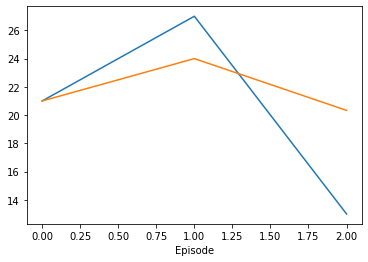

In [9]:
env.close( )
plt.plot( numsteps )
plt.plot( avg_numsteps )
plt.xlabel('Episode')
plt.show()

# Run the optimal policy (i.e., optimal neural network)


In [15]:
is_save_video = True

env = gym.make( 'CartPole-v1' )

# Saving the path 
# model_path = "../models/PG_raw_best_model.pth"
model_path = "../models/PG_white_best_model_1p0.pth"

# Load the pyTorch Model
model = torch.load( model_path )


# Run trial
state = env.reset()   

frames = []
# The maximum trial is 500 for the cart-and-pole
for _ in range( 500 ):

    if is_save_video: frames.append( env.render( mode = "rgb_array")  )
    env.render( )

    # Get the choice of action and the pi( a_t | s_t ) for the gradient calculation
    action, _ = model.get_action( state )
    new_state, _, done, _ = env.step( action )

    # If the trail encounters the terminal state
    if done: 
        break
    state = new_state

# Save Video
env.close( )

if is_save_video:
    clip = mpy.ImageSequenceClip( frames, fps = 30 )
    clip.write_gif( "../videos/circle.gif" )

MoviePy - Building file ../videos/circle.gif with imageio.


: 

# References 

- [1] [Great post on Github](https://github.com/dennybritz/reinforcement-learning/blob/master/PolicyGradient/README.md)
- [2] [Policy Gradient with Stephan Curry](https://jonathan-hui.medium.com/rl-policy-gradients-explained-9b13b688b146)
- [3] [Policy Gradient in a Nutshell](https://towardsdatascience.com/policy-gradients-in-a-nutshell-8b72f9743c5d)
- [4] [Pong from Pixels](http://karpathy.github.io/2016/05/31/rl/)
- [5] [Great post from Dr. Daniel Seita](https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/)